In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
%load_ext autoreload
%autoreload 2

from DLC_for_WBFM.utils.feature_detection.utils_features import *
from DLC_for_WBFM.utils.feature_detection.utils_tracklets import *
from DLC_for_WBFM.utils.feature_detection.utils_detection import *
from DLC_for_WBFM.utils.feature_detection.visualization_tracks import *
from DLC_for_WBFM.utils.feature_detection.feature_pipeline import *
from DLC_for_WBFM.utils.feature_detection.utils_affine import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Get the 3d bigtiff folder
bigtiff_folder = r'D:\More-stabilized-wbfm'

btf_fname_red = r'test2020-10-22_16-15-20_test4-channel-0-pco_camera1\test2020-10-22_16-15-20_test4-channel-0-pco_camera1bigtiff.btf'
btf_fname_red = os.path.join(bigtiff_folder, btf_fname_red)

# Annotations in the same folder as the .btf
external_annotations = r'test2020-10-22_16-15-20_test4-channel-0-pco_camera1\masks-500.pickle'
external_annotations = os.path.join(bigtiff_folder, external_annotations)

In [7]:
p = PreprocessingSettings()
p.do_filtering=False
p.do_rigid_alignment=True
p.do_mini_max_projection=True

# Get two sets of matches: affine, and feature-based
opt = {'start_frame':50,
       'num_frames':5,
       'num_slices':33,
      'use_affine_matching':True,
       'external_detections':external_annotations}
out = track_neurons_full_video(btf_fname_red, **opt, preprocessing_settings=p)
a_matches, a_conf, a_frames, a_candidates = out

opt = {'start_frame':50,
       'num_frames':5,
       'num_slices':33,
      'use_affine_matching':False,
       'external_detections':external_annotations}
out = track_neurons_full_video(btf_fname_red, **opt, preprocessing_settings=p)
f_matches, f_conf, f_frames, f_candidates = out

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.11s/it]


## Plotting

In [31]:

k = (53,54)

a0_unmatched = a_frames[k[0]].neuron_locs
a1_unmatched = a_frames[k[1]].neuron_locs
this_match, this_conf = a_matches[k], a_conf[k]
# all_m, all_c, to_remove_ind = keep_best_match(this_match, this_conf)

a_xyz = np.zeros((len(this_match), 3), dtype=np.float32) # Start point
a_dat = np.zeros((len(this_match), 3), dtype=np.float32) # Difference vector
for m, match in enumerate(this_match):
    v0 = a0_unmatched[match[0]]
    v1 = a1_unmatched[match[1]]
    a_xyz[m, :] = v0
    a_dat[m, :] = v1 - v0

f0_unmatched = f_frames[k[0]].neuron_locs
f1_unmatched = f_frames[k[1]].neuron_locs
this_match, this_conf = f_matches[k], f_conf[k]
# all_m, all_c, to_remove_ind = keep_best_match(this_match, this_conf)

f_xyz = np.zeros((len(this_match), 3), dtype=np.float32) # Start point
f_dat = np.zeros((len(this_match), 3), dtype=np.float32) # Difference vector
for m, match in enumerate(this_match):
    v0 = f0_unmatched[match[0]]
    v1 = f1_unmatched[match[1]]
    f_xyz[m, :] = v0
    f_dat[m, :] = v1 - v0

<IPython.core.display.Javascript object>


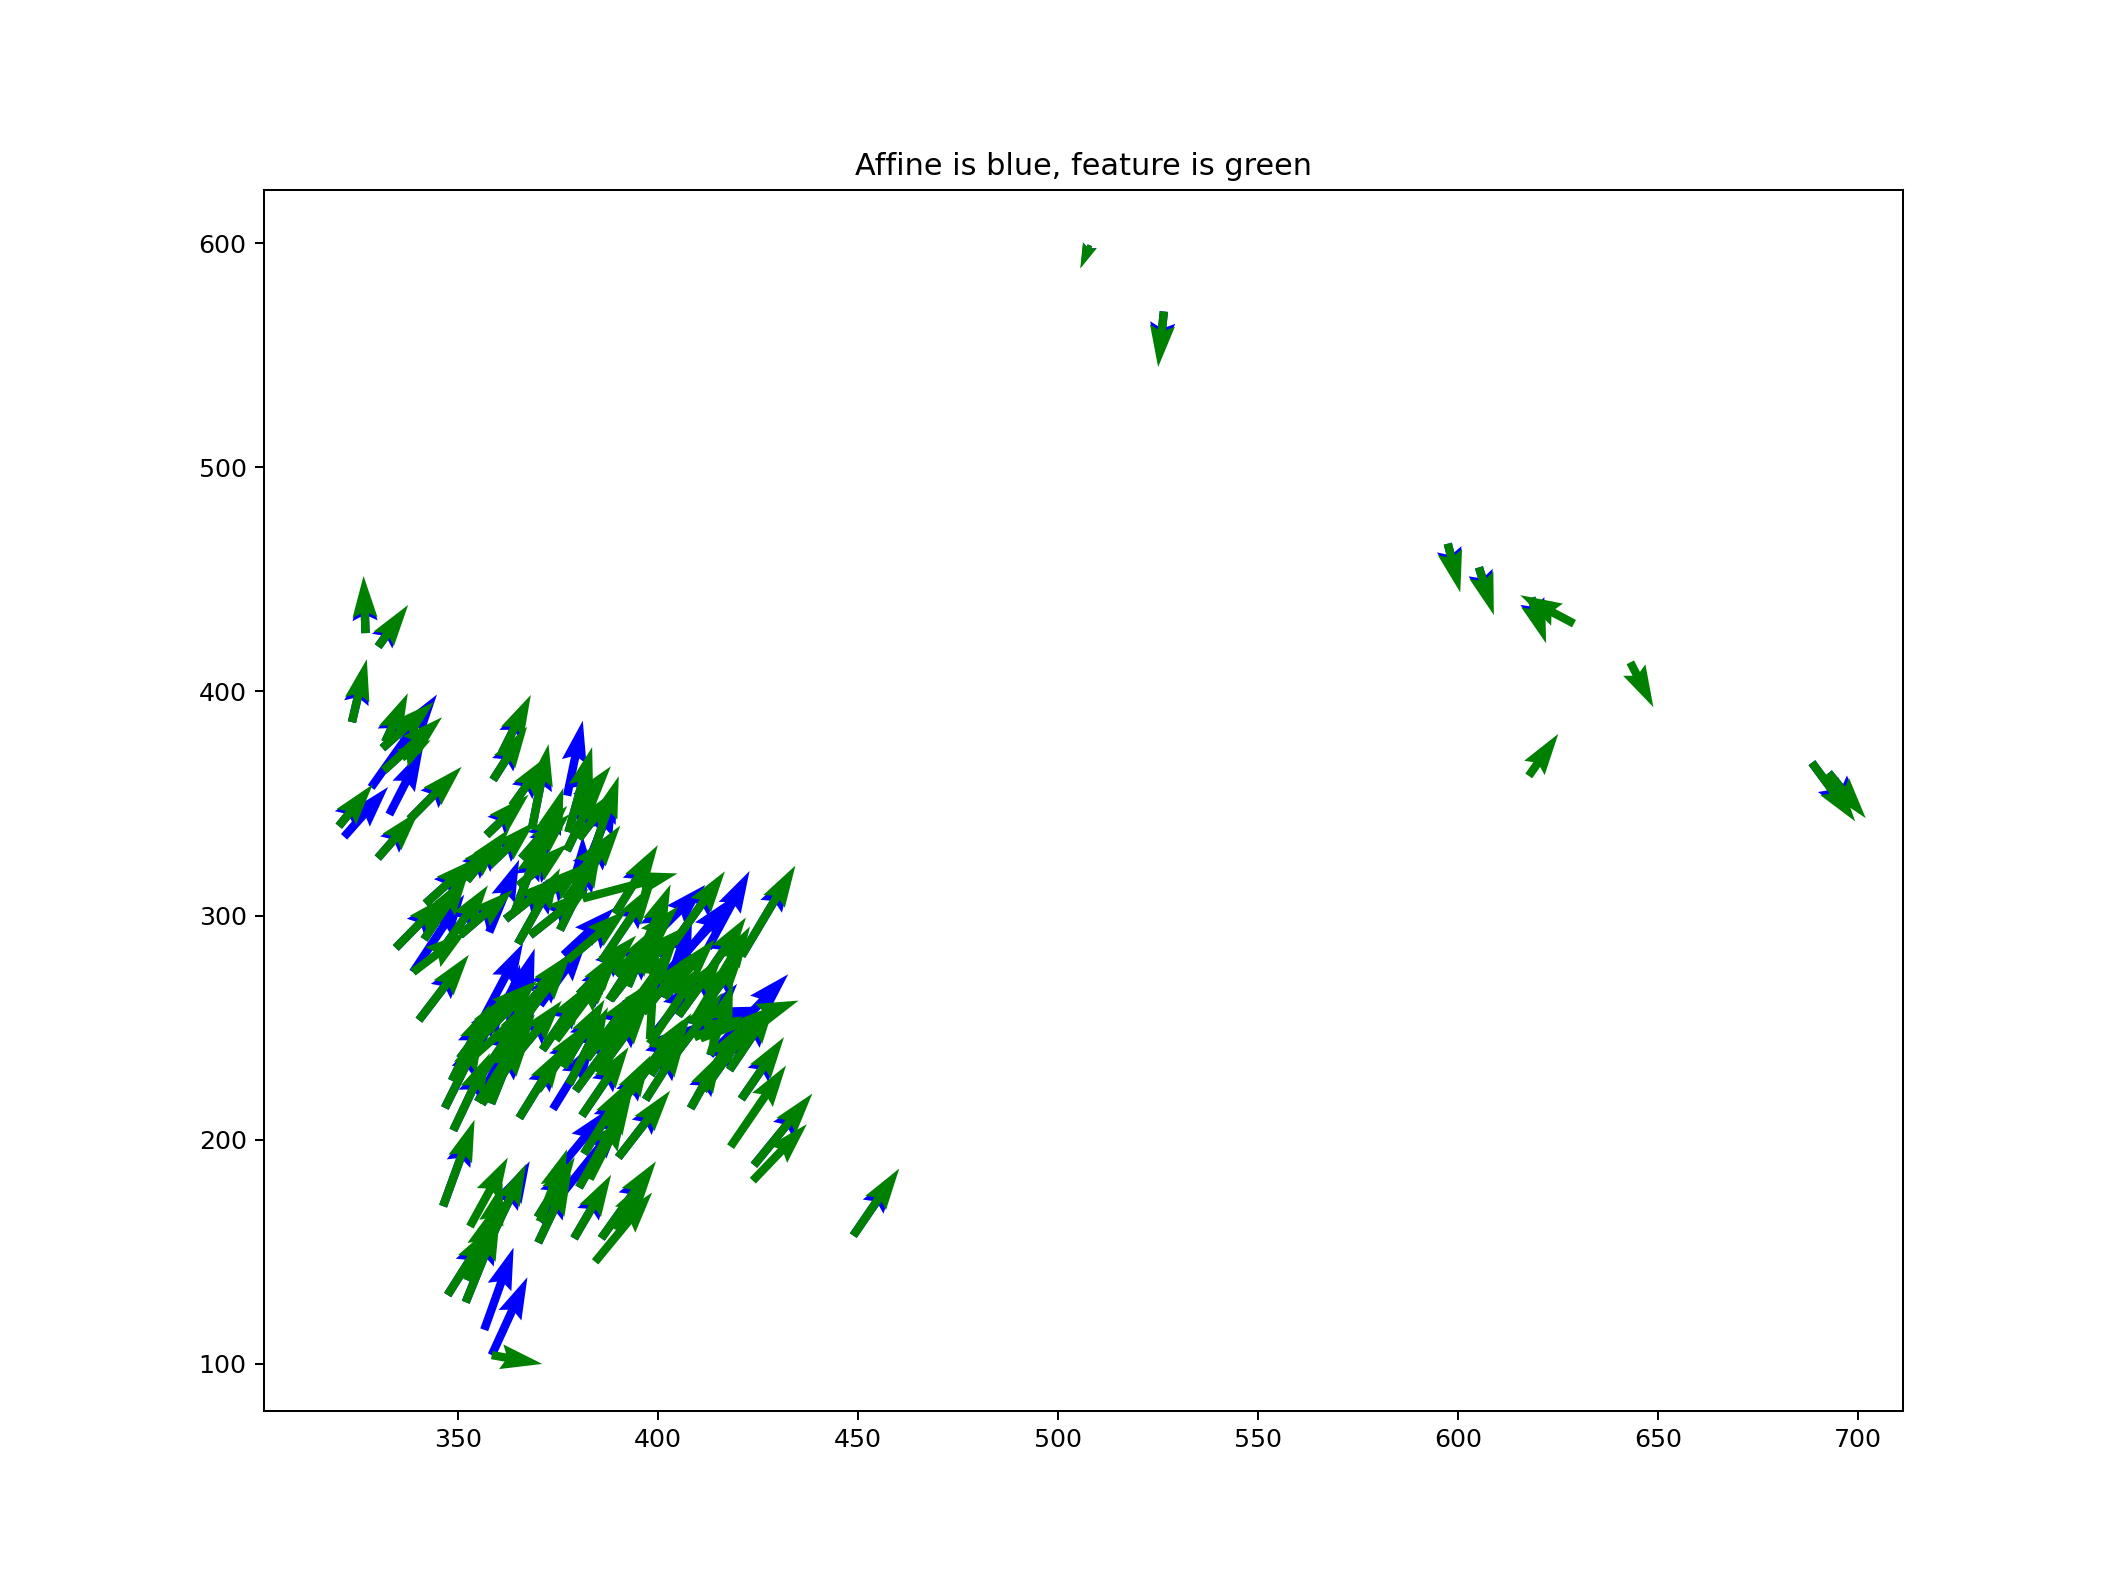

Text(0.5, 1.0, 'Affine is blue, feature is green')

In [32]:
%matplotlib notebook

# C = dat[:,2] / np.max(dat[:,1])
plt.quiver(a_xyz[:,1], a_xyz[:,2], a_dat[:,1], a_dat[:,2], color='blue')

# C = f_dat[:,2] / np.max(f_dat[:,1])
plt.quiver(f_xyz[:,1], f_xyz[:,2], f_dat[:,1], f_dat[:,2], color='green')

plt.title("Affine is blue, feature is green")

In [34]:

# Affine
pc0 = build_neuron_tree(a_xyz, False)[1]
pc1 = build_neuron_tree(a_xyz+a_dat, False)[1]

affine_lines = build_line_set_from_matches(pc0, pc1, matches=None)

# Feature (same points, ordered differently)
pc0 = build_neuron_tree(f_xyz, False)[1]
pc1 = build_neuron_tree(f_xyz+f_dat, False)[1]

feature_lines = build_line_set_from_matches(pc0, pc1, matches=None, color=[1,0,0])
# Offset for visualization
feature_lines.translate(np.array([0.5,0.5,0.5]))

# Define full point clouds
pc0 = build_neuron_tree(a0_unmatched, False)[1]
pc0.paint_uniform_color([0,0,0])
pc1 = build_neuron_tree(a1_unmatched, False)[1]
pc1.paint_uniform_color([0.5,0.5,0.5])

print("Feature lines are red, Affine, are blue")

Feature lines are red, Affine, are blue


In [36]:
o3d.visualization.draw_geometries([pc0, pc1, affine_lines, feature_lines])